<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/LohnasKahana2014.csv"
trial_query = "condition == 1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "LohnasKahanaCond1"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function murdock_objective_function.<locals>.objective_function at 0x2acfc66aa4c0>


1275.5688396813282
3453.8778694933385


<function murdock_objective_function.<locals>.objective_function at 0x2acfc7c9eb80>


1275.5688396813282
3453.8778694933385
<function murdock_objective_function.<locals>.objective_function at 0x2acfc7e20f70>


1275.5688396813282
3453.8778694933385
<function murdock_objective_function.<locals>.objective_function at 0x2acfc80a49d0>


1275.5688396813282
3453.8778694933385
<function murdock_objective_function.<locals>.objective_function at 0x2acfc819eca0>


1275.5688396813282
3453.8778694933385
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag LohnasKahanaCond1 already exist
ICMR_1_0_0, Subject 1


688.3020449386952
ICMR_1_0_0, Subject 2


415.76776446348083
ICMR_1_0_0, Subject 3


684.4055724746333
ICMR_1_0_0, Subject 4


282.66114836490664
ICMR_1_0_0, Subject 5


663.2647323521292
ICMR_1_0_0, Subject 6


640.2292555354418
ICMR_1_0_0, Subject 7


317.8099052167371
ICMR_1_0_0, Subject 8


599.1184344610921
ICMR_1_0_0, Subject 10


468.85713389416685
ICMR_1_0_0, Subject 11


850.7253480781585
ICMR_1_0_0, Subject 12


696.4436867542069
ICMR_1_0_0, Subject 13


759.277505292142
ICMR_1_0_0, Subject 14


891.9571804518955
ICMR_1_0_0, Subject 15


476.32385864734624
ICMR_1_0_0, Subject 16


584.476257611753
ICMR_1_0_0, Subject 17


549.3787191553578
ICMR_1_0_0, Subject 18


557.171894649981
ICMR_1_0_0, Subject 19


528.1508617447821
ICMR_1_0_0, Subject 20


371.8689435772945
ICMR_1_0_0, Subject 21


557.6001870335142
ICMR_1_0_0, Subject 22


386.6604446314961
ICMR_1_0_0, Subject 23


369.0022798573826
ICMR_1_0_0, Subject 24


413.94361310050914
ICMR_1_0_0, Subject 25


598.0050382610968
ICMR_1_0_0, Subject 27


354.14956714132603
ICMR_1_0_0, Subject 28


301.8866536237642
ICMR_1_0_0, Subject 29


474.20275414267553
ICMR_1_0_0, Subject 30


380.4369814360312
ICMR_1_0_0, Subject 31


426.38477006376047
ICMR_1_0_0, Subject 32


643.9884169766717
ICMR_1_0_0, Subject 33


447.59764528859125
ICMR_1_0_0, Subject 34


509.252198131678
ICMR_1_0_0, Subject 35


625.0679126680516
ICMR_1_0_0, Subject 36


473.3307925343428
ICMR_1_0_0, Subject 37


256.1863400349557


ICMR_1_0_1, Subject 1


694.1440381490117
ICMR_1_0_1, Subject 2


410.86375398352976
ICMR_1_0_1, Subject 3


692.3757487228646
ICMR_1_0_1, Subject 4


281.8766997736836
ICMR_1_0_1, Subject 5


663.774357520057
ICMR_1_0_1, Subject 6


640.3572569848576
ICMR_1_0_1, Subject 7


317.75684011771875
ICMR_1_0_1, Subject 8


599.7350173431712
ICMR_1_0_1, Subject 10


469.04880432795983
ICMR_1_0_1, Subject 11


871.9354659581135
ICMR_1_0_1, Subject 12


695.9021575157124
ICMR_1_0_1, Subject 13


758.4712285363528
ICMR_1_0_1, Subject 14


891.8908337289173
ICMR_1_0_1, Subject 15


475.93256146322625
ICMR_1_0_1, Subject 16


591.2572931797315
ICMR_1_0_1, Subject 17


547.088179233506
ICMR_1_0_1, Subject 18


559.2784000639676
ICMR_1_0_1, Subject 19


528.6740656487689
ICMR_1_0_1, Subject 20


370.05203131664905
ICMR_1_0_1, Subject 21


558.2695390095631
ICMR_1_0_1, Subject 22


385.44432578429183
ICMR_1_0_1, Subject 23


353.35531371141917
ICMR_1_0_1, Subject 24


412.9411609908466
ICMR_1_0_1, Subject 25


594.6898245974257
ICMR_1_0_1, Subject 27


351.504620878738
ICMR_1_0_1, Subject 28


296.94383452666233
ICMR_1_0_1, Subject 29


469.4454179517686
ICMR_1_0_1, Subject 30


371.65111249105627
ICMR_1_0_1, Subject 31


425.9983427084607
ICMR_1_0_1, Subject 32


643.4931803064533
ICMR_1_0_1, Subject 33


450.2272242264026
ICMR_1_0_1, Subject 34


507.8270303006618
ICMR_1_0_1, Subject 35


625.740093217922
ICMR_1_0_1, Subject 36


471.8282463146677
ICMR_1_0_1, Subject 37


255.15750721514647
ICMR_1_1_0, Subject 1


691.8854171304502
ICMR_1_1_0, Subject 2


415.87578235332825
ICMR_1_1_0, Subject 3


692.3937582001282
ICMR_1_1_0, Subject 4


282.7718978757799
ICMR_1_1_0, Subject 5


664.0010418853415
ICMR_1_1_0, Subject 6


640.3165324071007
ICMR_1_1_0, Subject 7


317.6067602322855
ICMR_1_1_0, Subject 8


603.4795801135107
ICMR_1_1_0, Subject 10


468.38254389388436
ICMR_1_1_0, Subject 11


853.6456277859533
ICMR_1_1_0, Subject 12


693.6585058862606
ICMR_1_1_0, Subject 13


758.653371556681
ICMR_1_1_0, Subject 14


893.5590746060193
ICMR_1_1_0, Subject 15


474.47013152815276
ICMR_1_1_0, Subject 16


576.9809430414806
ICMR_1_1_0, Subject 17


546.9186308136518
ICMR_1_1_0, Subject 18


556.6464336906862
ICMR_1_1_0, Subject 19


525.739875255557
ICMR_1_1_0, Subject 20


371.2503921219981
ICMR_1_1_0, Subject 21


553.8144377615145
ICMR_1_1_0, Subject 22


388.7004333272388
ICMR_1_1_0, Subject 23


355.3316177416726
ICMR_1_1_0, Subject 24


411.563559545975
ICMR_1_1_0, Subject 25


592.7449102768569
ICMR_1_1_0, Subject 27


352.5981496334076
ICMR_1_1_0, Subject 28


296.75377602154566
ICMR_1_1_0, Subject 29


476.41009222927664
ICMR_1_1_0, Subject 30


371.8067537508312
ICMR_1_1_0, Subject 31


426.6471166501013
ICMR_1_1_0, Subject 32


643.364348550842
ICMR_1_1_0, Subject 33


456.90723386264375
ICMR_1_1_0, Subject 34


498.3401957689568
ICMR_1_1_0, Subject 35


624.8113251765703
ICMR_1_1_0, Subject 36


478.1350359593342
ICMR_1_1_0, Subject 37


255.85946087915002
ICMR_1_1_1, Subject 1


689.9429419296428
ICMR_1_1_1, Subject 2


410.66262594968305
ICMR_1_1_1, Subject 3


684.6492251804577
ICMR_1_1_1, Subject 4


282.7046741375745
ICMR_1_1_1, Subject 5


663.9765730336185
ICMR_1_1_1, Subject 6


640.5341115241708
ICMR_1_1_1, Subject 7


317.71644478865744
ICMR_1_1_1, Subject 8


599.6570301061208
ICMR_1_1_1, Subject 10


469.1121722035443
ICMR_1_1_1, Subject 11


842.7501860371683
ICMR_1_1_1, Subject 12


693.5588657006451
ICMR_1_1_1, Subject 13


765.7885778321235
ICMR_1_1_1, Subject 14


894.1516763628529
ICMR_1_1_1, Subject 15


474.13418518266366
ICMR_1_1_1, Subject 16


587.9374473050382
ICMR_1_1_1, Subject 17


546.9041059205829
ICMR_1_1_1, Subject 18


557.1495077219258
ICMR_1_1_1, Subject 19


525.5795543740865
ICMR_1_1_1, Subject 20


371.8452120694576
ICMR_1_1_1, Subject 21


558.7610932867958
ICMR_1_1_1, Subject 22


383.56351160725336
ICMR_1_1_1, Subject 23


359.96201268199445
ICMR_1_1_1, Subject 24


412.9020282914665
ICMR_1_1_1, Subject 25


597.6919176620827
ICMR_1_1_1, Subject 27


352.79212466295417
ICMR_1_1_1, Subject 28


296.13948354108334
ICMR_1_1_1, Subject 29


472.10265928475366
ICMR_1_1_1, Subject 30


374.16728609258604
ICMR_1_1_1, Subject 31


428.56671196574655
ICMR_1_1_1, Subject 32


643.4171013279622
ICMR_1_1_1, Subject 33


462.1133185740455
ICMR_1_1_1, Subject 34


499.38757216338723
ICMR_1_1_1, Subject 35


625.9264688082486
ICMR_1_1_1, Subject 36


471.3484670731215
ICMR_1_1_1, Subject 37


254.21851598356716


Text(-1.8055555555555483, 0.5, 'Individual Log-Likelihood')

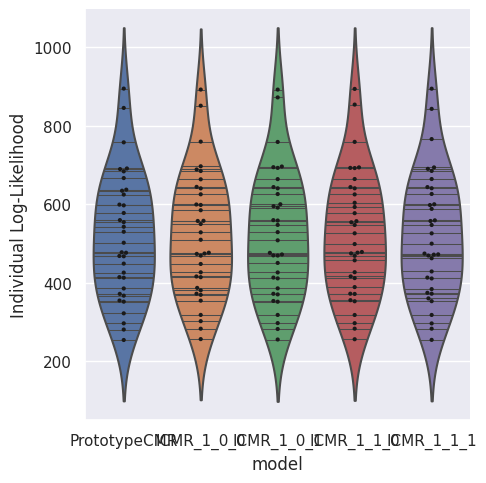

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,1,12,690.878732,PrototypeCMR,0.643159,0.615549,0.949657,0.516430,4.653396e-01,0.581203,0.434397,9.725498,0.000097,0.363230,7.720268,5.981709e-01,NaN,NaN,NaN
1,2,12,412.624966,PrototypeCMR,0.674161,0.571281,0.973806,1.000000,8.179991e-01,1.000000,0.413154,99.565120,0.011052,0.266474,9.248449,3.967386e-07,NaN,NaN,NaN
2,3,12,689.357088,PrototypeCMR,0.828218,0.023595,0.926296,0.021927,2.220446e-16,0.611047,19.829403,41.905339,0.007402,0.127703,1.149134,6.957215e-06,NaN,NaN,NaN
3,4,12,280.515004,PrototypeCMR,0.922606,0.003423,0.997730,0.002085,2.220446e-16,0.501359,100.000000,20.281386,0.080067,0.085179,0.506712,2.220446e-16,NaN,NaN,NaN
4,5,12,666.457217,PrototypeCMR,0.525528,1.000000,0.881813,0.250809,9.528331e-01,0.316558,0.112244,16.715853,0.001519,0.238068,4.289363,9.999707e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,33,12,462.113319,ICMR_1_1_1,0.036203,0.001095,0.400726,0.508552,2.120729e-02,0.834113,47.936819,0.382511,0.011676,0.223518,1.000000,9.999823e-01,1.0,5.328114,True
171,34,12,499.387572,ICMR_1_1_1,0.768496,0.385153,0.949815,0.001127,1.842345e-01,0.360269,15.255077,0.852789,0.004812,0.169601,1.000000,1.303570e-01,1.0,1.764181,True
172,35,12,625.926469,ICMR_1_1_1,0.744208,0.612959,0.950653,0.032584,9.782764e-01,0.796325,8.340752,35.588294,0.002193,0.222231,1.000000,2.520756e-02,1.0,4.128442,True
173,36,12,471.348467,ICMR_1_1_1,0.773284,0.564063,0.865271,0.009581,7.149118e-01,0.729596,4.033138,0.216130,0.014784,0.179567,1.000000,2.470793e-01,1.0,1.424710,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-LohnasKahanaCond1fits layout-nrow=2 layout-valign="center"}

![](results/individual_LohnasKahanaCond1.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       35     |       35     |       35     |       35     |         35     |
| mean  |      521.254 |      520.998 |      520.344 |      520.338 |        518.71  |
| std   |      157.364 |      160.449 |      158.567 |      158.237 |        157.923 |
| min   |      256.186 |      255.158 |      255.859 |      254.219 |        253.914 |
| 25%   |      400.302 |      398.154 |      400.132 |      397.113 |        398.9   |
| 50%   |      509.252 |      507.827 |      498.34  |      499.388 |        501.706 |
| 75%   |      632.649 |      633.049 |      632.564 |      633.23  |        629.315 |
| max   |      891.957 |      891.891 |      893.559 |      894.152 |        894.405 |

Distributio

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-3.196822217055779, pvalue=0.0029991861083354665)
Ttest_relResult(statistic=-3.196822217055779, pvalue=0.0014995930541677333)
Ttest_relResult(statistic=-3.196822217055779, pvalue=0.9985004069458322)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-2.3062705216035853, pvalue=0.027320243970006243)
Ttest_relResult(statistic=-2.3062705216035853, pvalue=0.013660121985003121)
Ttest_relResult(statistic=-2.3062705216035853, pvalue=0.9863398780149969)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-2.3715491502352473, pvalue=0.023519132628882344)
Ttest_relResult(statistic=-2.3715491502352473, pvalue=0.011759566314441172)
Ttest_relResult(statistic=-2.3715491502352473, pvalue=0.9882404336855588)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-2.0903295795212804, pvalue=0.04413815964193697)
Ttest_relResult(statistic=-2.0903295795212804, pvalue=0.022069079820968486)
Ttest_relResult(statistic=-2.0903295795212804

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.6857142857142857 0.3142857142857143
24 11

('PrototypeCMR', 'ICMR_1_0_1')
0.6571428571428571 0.34285714285714286
23 12

('PrototypeCMR', 'ICMR_1_1_0')
0.7142857142857143 0.2857142857142857
25 10

('PrototypeCMR', 'ICMR_1_1_1')
0.5714285714285714 0.42857142857142855
20 15

('ICMR_1_0_0', 'ICMR_1_0_1')
0.37142857142857144 0.6285714285714286
13 22

('ICMR_1_0_0', 'ICMR_1_1_0')
0.4 0.6
14 21

('ICMR_1_0_0', 'ICMR_1_1_1')
0.4 0.6
14 21

('ICMR_1_0_1', 'ICMR_1_1_0')
0.4857142857142857 0.5142857142857142
17 18

('ICMR_1_0_1', 'ICMR_1_1_1')
0.45714285714285713 0.5428571428571428
16 19

('ICMR_1_1_0', 'ICMR_1_1_1')
0.5428571428571428 0.45714285714285713
19 16



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[1.00000000e+00 2.18070298e-39 1.68816428e-35 1.49862956e-25
 1.84763827e-25]


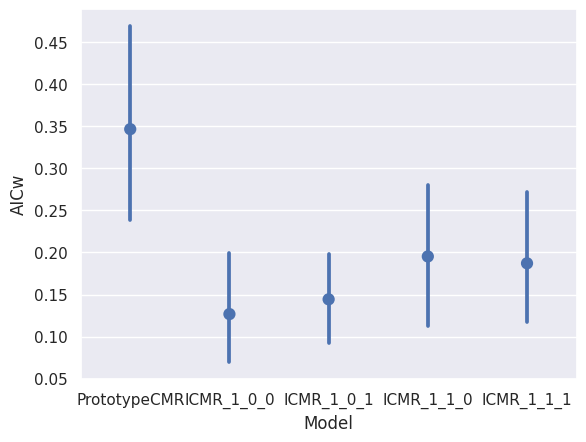

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined